In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel
import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 74))
variables_test = np.empty((0, 74))

# Truth
y_train = np.empty((0, 4))
y_test = np.empty((0, 4))
trueParentChildLink_train = np.empty((0), dtype='int')
trueParentChildLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    trueParentChildLink_train = np.concatenate((trueParentChildLink_train, data['trueParentChildLink_train']), axis=0)
    trueParentChildLink_test = np.concatenate((trueParentChildLink_test, data['trueParentChildLink_test']), axis=0)


Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (569771, 74)
variables_test.shape: (63307, 74)
y_train.shape: (569771, 4)
y_test.shape: (63307, 4)
trueParentChildLink_train.shape: (569771,)
trueParentChildLink_test.shape: (63307,)


In [6]:
###########################################################
# Split it into four again
###########################################################

n_links = 4
n_global_vars = 6
n_link_vars = 17

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train = variables_train
input_1_train = np.concatenate((input_0_train[:,0:i_end_of_global_vars], input_0_train[:,i_target_start:], input_0_train[:,i_rest_start:i_rest_end]), axis=1)
input_2_train = np.concatenate((input_1_train[:,0:i_end_of_global_vars], input_1_train[:,i_target_start:], input_1_train[:,i_rest_start:i_rest_end]), axis=1)
input_3_train = np.concatenate((input_2_train[:,0:i_end_of_global_vars], input_2_train[:,i_target_start:], input_2_train[:,i_rest_start:i_rest_end]), axis=1)

input_train = np.concatenate((input_0_train, input_1_train, input_2_train, input_3_train), axis=0)
truth_train = np.concatenate((y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3]), axis=0).reshape(-1,1)

# Test
input_0_test = variables_test
input_1_test = np.concatenate((input_0_test[:,0:i_end_of_global_vars], input_0_test[:,i_target_start:], input_0_test[:,i_rest_start:i_rest_end]), axis=1)
input_2_test = np.concatenate((input_1_test[:,0:i_end_of_global_vars], input_1_test[:,i_target_start:], input_1_test[:,i_rest_start:i_rest_end]), axis=1)
input_3_test = np.concatenate((input_2_test[:,0:i_end_of_global_vars], input_2_test[:,i_target_start:], input_2_test[:,i_rest_start:i_rest_end]), axis=1)

input_test = np.concatenate((input_0_test, input_1_test, input_2_test, input_3_test), axis=0)
truth_test = np.concatenate((y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3]), axis=0).reshape(-1,1)

In [7]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)
print('input_2_train:', input_2_train.shape)
print('input_3_train:', input_3_train.shape)
print('input_train:', input_train.shape)
print('truth_train:', truth_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)
print('input_2_test:', input_2_test.shape)
print('input_3_test:', input_3_test.shape)
print('input_test:', input_test.shape)
print('truth_test:', truth_test.shape)

input_0_train: (569771, 74)
input_1_train: (569771, 74)
input_2_train: (569771, 74)
input_3_train: (569771, 74)
input_train: (2279084, 74)
truth_train: (2279084, 1)
input_0_test: (63307, 74)
input_1_test: (63307, 74)
input_2_test: (63307, 74)
input_3_test: (63307, 74)
input_test: (253228, 74)
truth_test: (253228, 1)


In [8]:
###########################################################
# Define class weights
###########################################################
nTrue = np.count_nonzero(truth_train == 1)
nWrongOrientation = np.count_nonzero(truth_train == 2)
nBackground = np.count_nonzero(truth_train == 0)
maxLinks = max(nTrue, nWrongOrientation, nBackground)

print('nTrue:', nTrue)
print('nWrongOrientation:', nWrongOrientation)
print('nBackground:', nBackground)

classWeights = {0: maxLinks/nBackground, 1: maxLinks/nTrue, 2: maxLinks/nWrongOrientation}

print('classWeights:', classWeights)

nTrue: 65974
nWrongOrientation: 197922
nBackground: 2015188
classWeights: {0: 1.0, 1: 30.545184466608056, 2: 10.18172815553602}


In [9]:
###########################################################
# Change format of truth labels
###########################################################

trueParentChildLink_train = trueParentChildLink_train.reshape(-1, 1)
trueParentChildLink_test = trueParentChildLink_test.reshape(-1, 1)

trueParentChildLink_train = to_categorical(trueParentChildLink_train, 2)
trueParentChildLink_test = to_categorical(trueParentChildLink_test, 2)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

truth_train = to_categorical(truth_train, 3)
truth_test = to_categorical(truth_test, 3)

In [10]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['categorical_crossentropy'])

In [11]:
###########################################################
# Fit the model
###########################################################

filePath = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries'
    
# checkpoint
checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(input_train, truth_train, validation_data=(input_test, truth_test), 
                    batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list, class_weight=classWeights)

Epoch 1/10
35590/35611 [============================>.] - ETA: 0s - loss: 1.9945 - accuracy: 0.8060
Epoch 1: val_accuracy improved from -inf to 0.82707, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 75s 2ms/step - loss: 1.9944 - accuracy: 0.8060 - val_loss: 0.5345 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 2/10
35590/35611 [============================>.] - ETA: 0s - loss: 1.8605 - accuracy: 0.8249
Epoch 2: val_accuracy improved from 0.82707 to 0.84541, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 60s 2ms/step - loss: 1.8604 - accuracy: 0.8249 - val_loss: 0.4550 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 3/10
35610/35611 [============================>.] - ETA: 0s - loss: 1.8228 - accuracy: 0.8301
Epoch 3: val_accuracy improved from 0.84541 to 0.85562, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 55s 2ms/step - loss: 1.8228 - accuracy: 0.8301 - val_loss: 0.4323 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 4/10
35572/35611 [============================>.] - ETA: 0s - loss: 1.8030 - accuracy: 0.8342
Epoch 4: val_accuracy did not improve from 0.85562
35611/35611 [==============================] - 56s 2ms/step - loss: 1.8031 - accuracy: 0.8342 - val_loss: 0.4459 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 5/10
35565/35611 [============================>.] - ETA: 0s - loss: 1.7897 - accuracy: 0.8372
Epoch 5: val_accuracy improved from 0.85562 to 0.85826, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 42s 1ms/step - loss: 1.7895 - accuracy: 0.8372 - val_loss: 0.4029 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 6/10
35591/35611 [============================>.] - ETA: 0s - loss: 1.7760 - accuracy: 0.8373
Epoch 6: val_accuracy improved from 0.85826 to 0.86024, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 40s 1ms/step - loss: 1.7762 - accuracy: 0.8373 - val_loss: 0.4473 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 7/10
35573/35611 [============================>.] - ETA: 0s - loss: 1.7644 - accuracy: 0.8379
Epoch 7: val_accuracy did not improve from 0.86024

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
35611/35611 [==============================] - 38s 1ms/step - loss: 1.7645 - accuracy: 0.8379 - val_loss: 0.4411 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 8/10
35565/35611 [============================>.] - ETA: 0s - loss: 1.6915 - accuracy: 0.8470
Epoch 8: val_accuracy improved from 0.86024 to 0.86541, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


35611/35611 [==============================] - 41s 1ms/step - loss: 1.6913 - accuracy: 0.8470 - val_loss: 0.4022 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 9/10
35599/35611 [============================>.] - ETA: 0s - loss: 1.6740 - accuracy: 0.8495
Epoch 9: val_accuracy did not improve from 0.86541
35611/35611 [==============================] - 41s 1ms/step - loss: 1.6738 - accuracy: 0.8496 - val_loss: 0.4243 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 10/10
35584/35611 [============================>.] - ETA: 0s - loss: 1.6657 - accuracy: 0.8492
Epoch 10: val_accuracy did not improve from 0.86541
35611/35611 [==============================] - 39s 1ms/step - loss: 1.6656 - accuracy: 0.8492 - val_loss: 0.4007 - val_accuracy: 0.8637 - lr: 1.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


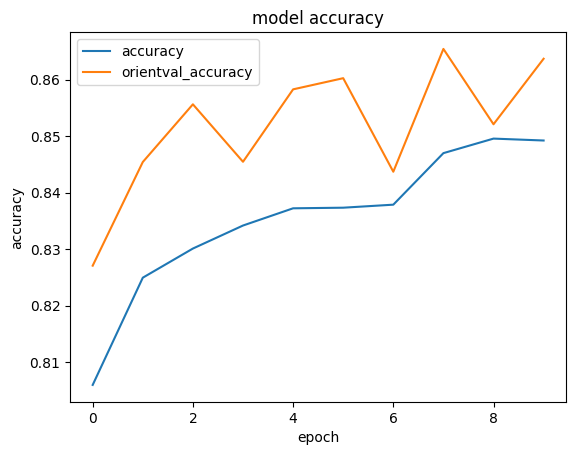

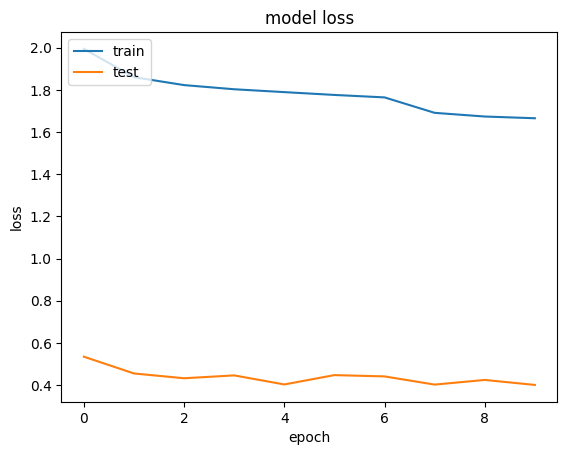

In [12]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_train = model.predict(input_train)
y_pred_test = model.predict(input_test)

7914/7914 [==============================] - 3s 339us/step


In [14]:
###########################################################
# Reshape the prediction for next network
###########################################################
y_pred_0_train = y_pred_train[0:ntrain].reshape(-1, 1, 3)
y_pred_1_train = y_pred_train[ntrain:(ntrain * 2)].reshape(-1, 1, 3)
y_pred_2_train = y_pred_train[(ntrain * 2):(ntrain * 3)].reshape(-1, 1, 3)
y_pred_3_train = y_pred_train[(ntrain * 3):].reshape(-1, 1, 3)
input_final_train = np.concatenate((y_pred_0_train, y_pred_1_train, y_pred_2_train, y_pred_3_train), axis=1).reshape(-1, 12)

y_pred_0_test = y_pred_test[0:ntest].reshape(-1, 1, 3)
y_pred_1_test = y_pred_test[ntest:(ntest * 2)].reshape(-1, 1, 3)
y_pred_2_test = y_pred_test[(ntest * 2):(ntest * 3)].reshape(-1, 1, 3)
y_pred_3_test = y_pred_test[(ntest * 3):].reshape(-1, 1, 3)
input_final_test = np.concatenate((y_pred_0_test, y_pred_1_test, y_pred_2_test, y_pred_3_test), axis=1).reshape(-1, 12)

In [15]:
###########################################################
# Reshape the prediction and truth labels for metrics
###########################################################

pred_individual_links_train = input_final_train.reshape(-1, 3)
y_train = y_train.reshape(-1, 3)

pred_individual_links_test = input_final_test.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

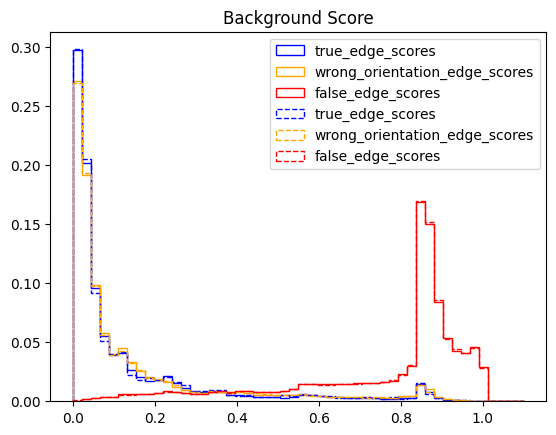

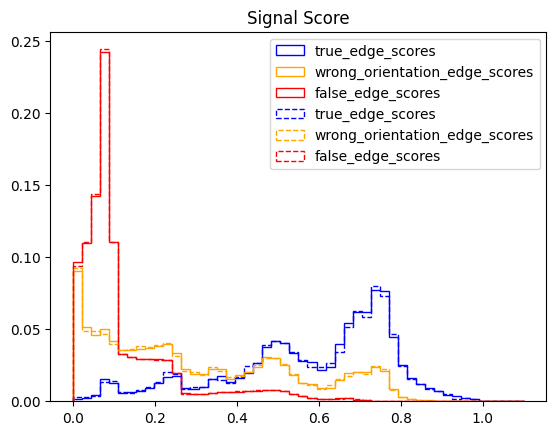

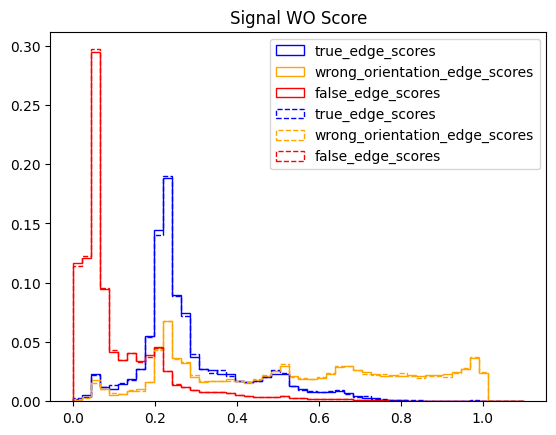

[[200044  14547   9209]
 [   759   5530   1068]
 [  2635   6303  13133]]


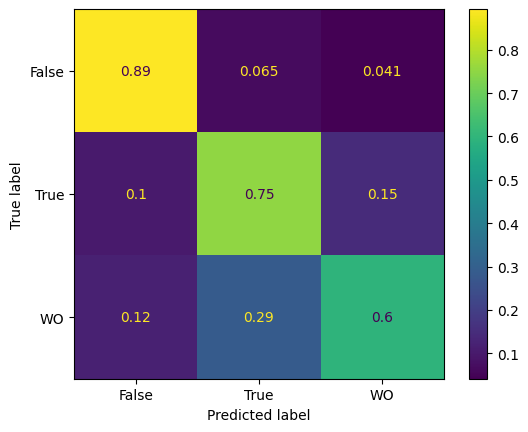

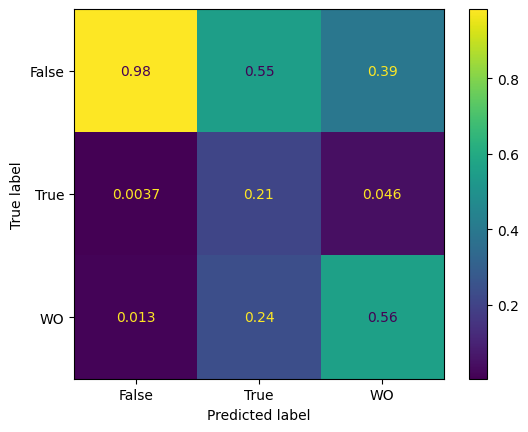

In [16]:
#######################################
# Plot edge scores
#######################################

PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 0)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 1)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 2)
PerformanceFuncs.draw_confusion_multi(pred_individual_links_test, y_test)

In [17]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = HigherTierModel.HigherTierFinalOutputModel(12, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['binary_crossentropy'])

In [18]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 1)
nBackground_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('classWeights_final:', classWeights_final)

classWeights_final: {0: 1.0, 1: 7.636296116652014}


In [19]:
###########################################################
# Reshape for sigmoid training
###########################################################

trueParentChildLink_train = trueParentChildLink_train.argmax(axis=1).reshape((-1,1))
trueParentChildLink_test = trueParentChildLink_test.argmax(axis=1).reshape((-1,1))

In [20]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit(input_final_train, trueParentChildLink_train, validation_data=(input_final_test, trueParentChildLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
8841/8903 [============================>.] - ETA: 0s - loss: 0.5248 - accuracy: 0.8870
Epoch 1: val_accuracy improved from -inf to 0.88426, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 440us/step - loss: 0.5248 - accuracy: 0.8870 - val_loss: 0.2708 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 2/10
8879/8903 [============================>.] - ETA: 0s - loss: 0.4854 - accuracy: 0.8885
Epoch 2: val_accuracy improved from 0.88426 to 0.88556, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 427us/step - loss: 0.4856 - accuracy: 0.8885 - val_loss: 0.2709 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 3/10
8787/8903 [============================>.] - ETA: 0s - loss: 0.4843 - accuracy: 0.8902
Epoch 3: val_accuracy improved from 0.88556 to 0.88796, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 431us/step - loss: 0.4843 - accuracy: 0.8902 - val_loss: 0.2663 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 4/10
8870/8903 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.8911
Epoch 4: val_accuracy improved from 0.88796 to 0.88835, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 428us/step - loss: 0.4839 - accuracy: 0.8911 - val_loss: 0.2674 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 5/10
8896/8903 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.8915
Epoch 5: val_accuracy improved from 0.88835 to 0.89061, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 426us/step - loss: 0.4838 - accuracy: 0.8915 - val_loss: 0.2625 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 6/10
8808/8903 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8917
Epoch 6: val_accuracy improved from 0.89061 to 0.89251, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 424us/step - loss: 0.4837 - accuracy: 0.8917 - val_loss: 0.2590 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 7/10
8887/8903 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8919
Epoch 7: val_accuracy did not improve from 0.89251
8903/8903 [==============================] - 4s 417us/step - loss: 0.4837 - accuracy: 0.8919 - val_loss: 0.2618 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 8/10
8842/8903 [============================>.] - ETA: 0s - loss: 0.4837 - accuracy: 0.8918
Epoch 8: val_accuracy improved from 0.89251 to 0.89383, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


8903/8903 [==============================] - 4s 428us/step - loss: 0.4837 - accuracy: 0.8919 - val_loss: 0.2552 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 9/10
8902/8903 [============================>.] - ETA: 0s - loss: 0.4837 - accuracy: 0.8920
Epoch 9: val_accuracy did not improve from 0.89383
8903/8903 [==============================] - 4s 416us/step - loss: 0.4837 - accuracy: 0.8920 - val_loss: 0.2571 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 10/10
8879/8903 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8919
Epoch 10: val_accuracy did not improve from 0.89383

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
8903/8903 [==============================] - 4s 417us/step - loss: 0.4837 - accuracy: 0.8919 - val_loss: 0.2580 - val_accuracy: 0.8927 - lr: 0.0010


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


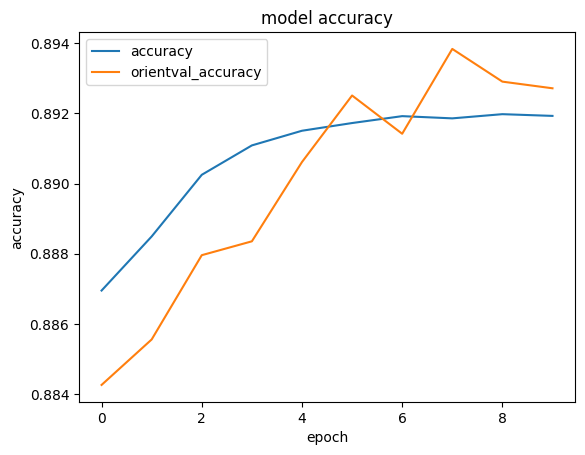

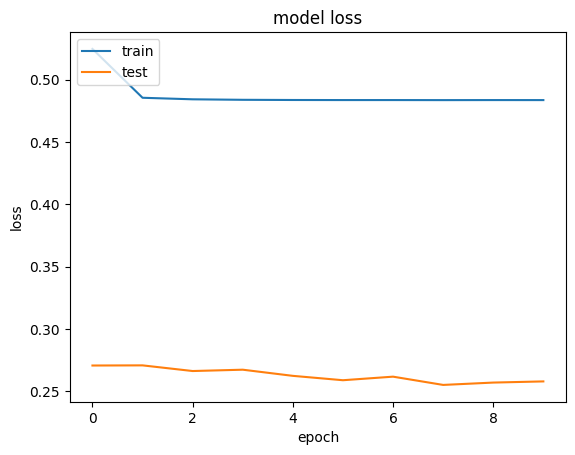

In [21]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict(input_final_train)
y_pred_final_test = model_final.predict(input_final_test)

1979/1979 [==============================] - 1s 255us/step


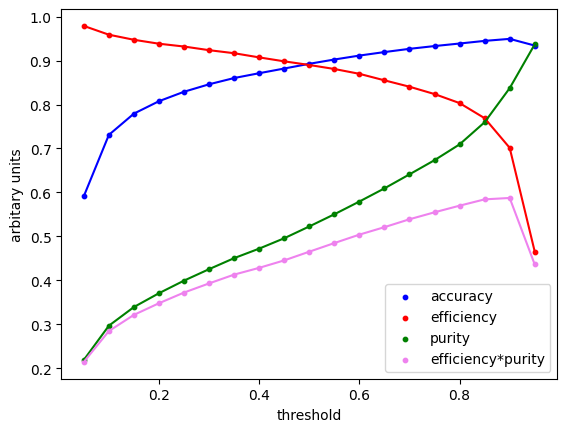

optimal_threshold_metric: 0.9000000000000001


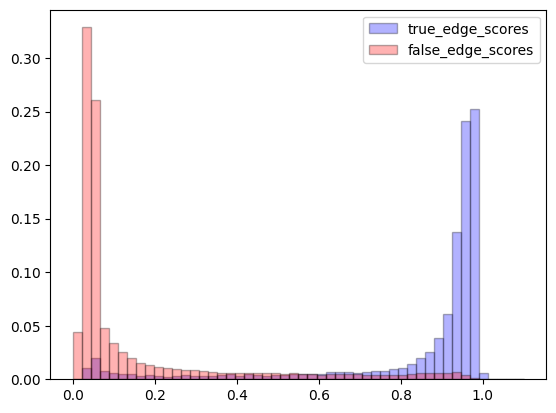

[[49967  5983]
 [  809  6548]]
[[54947  1003]
 [ 2196  5161]]


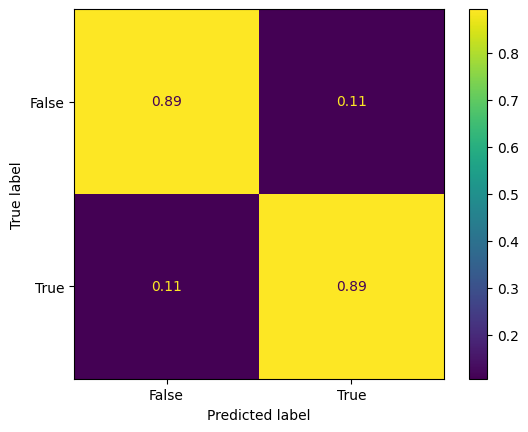

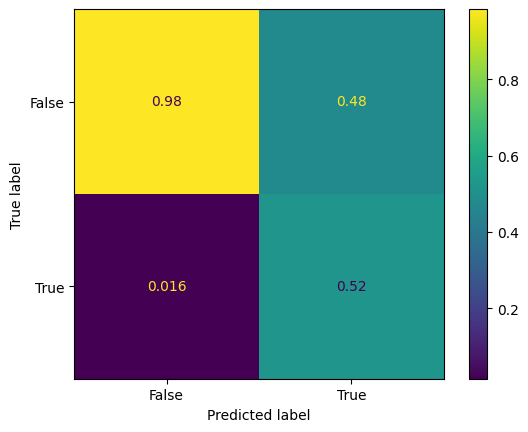

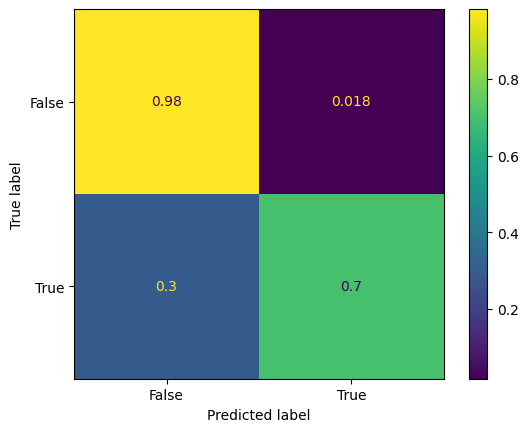

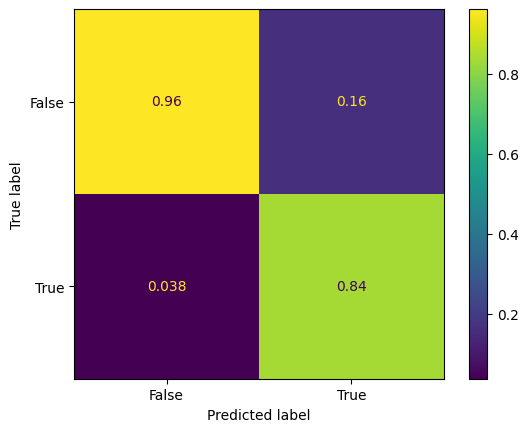

In [23]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, trueParentChildLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, trueParentChildLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, optimal_threshold_metric)
